# Talent Retention MLOps Notebook

## General settings

### Required libraries

In [1]:
import os
import shutil

from datetime import datetime
from io import StringIO, BytesIO
import json
from pathlib import Path

import boto3
from botocore.client import Config
import great_expectations as ge
import kagglehub
import pandas as pd
from pandera import Column, DataFrameSchema, Check

### General variables

In [2]:
project_root = Path(os.getcwd()).parent

### Common functions

In [3]:
from infisical_sdk import InfisicalSDKClient

def get_secret(secret_name: str) -> str:
    with open("{}/.infisical_token".format(project_root)) as f:
        token = f.read().strip()

    client = InfisicalSDKClient(
        host="http://localhost",
        token=token,
        cache_ttl=300
    )

    secret = client.secrets.get_secret_by_name(
        project_id="talent-retention-mlops",
        environment_slug="dev",
        secret_path="/",
        secret_name=secret_name
    )

    return secret.secretValue

def s3_client() -> boto3.client:
    minio_endpoint = "http://localhost:9000"
    access_key = get_secret("MINIO_ACCESS_KEY")
    secret_key = get_secret("MINIO_SECRET_KEY")

    return boto3.client(
                "s3",
                endpoint_url=minio_endpoint,
                aws_access_key_id=access_key,
                aws_secret_access_key=secret_key,
                config=Config(signature_version="s3v4"),
                region_name="us-east-1",
            )

In [5]:
def s3_client() -> boto3.client:
    minio_endpoint = "http://172.17.0.1:9000"
    access_key = get_secret("MINIO_ACCESS_KEY")
    secret_key = get_secret("MINIO_SECRET_KEY")

    return boto3.client(
                "s3",
                endpoint_url=minio_endpoint,
                aws_access_key_id=access_key,
                aws_secret_access_key=secret_key,
                config=Config(signature_version="s3v4"),
                region_name="us-east-1",
            )

bucket = "artifacts"
object_key = "builder/production/model.joblib"
destination = "bentoml/model.joblib"

os.makedirs("bentoml", exist_ok=True)

client = s3_client()
print(f"Downloading {object_key} from MinIO...")
client.download_file(bucket, object_key, destination)
print(f"Saven in {destination}")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f3ed0fb1010>>
Traceback (most recent call last):
  File "/code/talent-retention-mlops/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


EndpointConnectionError: Could not connect to the endpoint URL: "http://172.17.0.1:9000/artifacts/builder/production/model.joblib"

### Downloading the dataset

In [4]:
# https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/data
# pip install kagglehub[pandas-datasets]

dataset_name = "pavansubhasht/ibm-hr-analytics-attrition-dataset"

path = kagglehub.dataset_download(dataset_name)
destination = "{}/data/bronze/".format(project_root)

os.makedirs(destination, exist_ok=True)

for file_name in os.listdir(path):
    shutil.move(os.path.join(path, file_name), os.path.join(destination, file_name))

print(f"Dataset stored in: {destination}")

Dataset stored in: /code/talent-retention-mlops/data/bronze/


### Uploading dataset to MinIO

In [5]:
bucket_name = "datasets"
file_path = "{}/data/bronze/WA_Fn-UseC_-HR-Employee-Attrition.csv".format(project_root)

client = s3_client()

existing_buckets = [bucket["Name"] for bucket in client.list_buckets()["Buckets"]]
if bucket_name not in existing_buckets:
    client.create_bucket(Bucket=bucket_name)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
object_name = "bronze/{}/WA_Fn-UseC_-HR-Employee-Attrition.csv".format(timestamp)
client.upload_file(
    Filename = file_path, 
    Bucket = bucket_name,
    Key = object_name
    )

object_name = "bronze/latest/WA_Fn-UseC_-HR-Employee-Attrition.csv"
client.upload_file(
    Filename = file_path, 
    Bucket = bucket_name,
    Key = object_name
    )

## Data validation

### Load dataset from MinIO into pandas dataframe

In [ ]:

bucket_name = "datasets"
object_name = "bronze/latest/WA_Fn-UseC_-HR-Employee-Attrition.csv"

client = s3_client()
response = client.get_object(
    Bucket=bucket_name,
    Key=object_name
    )

csv_content = response['Body'].read().decode('utf-8')
df = pd.read_csv(StringIO(csv_content))
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### Running basic validations with great expectation library

In [7]:
gdf = ge.from_pandas(df)

gdf.expect_column_to_exist("Age")
gdf.expect_column_values_to_not_be_null("Age")
gdf.expect_column_values_to_be_between("Age", min_value=18, max_value=65)

gdf.expect_column_to_exist("Attrition")
gdf.expect_column_values_to_be_in_set("Attrition", ["Yes", "No"])

results = gdf.validate()

### Curating the dataframe using pandera library

In [8]:
if not results["success"]:
    schema = DataFrameSchema({
        "Age": Column(int, Check.in_range(18, 65), nullable=False),
        "Attrition": Column(str, Check.isin(["Yes", "No"]))
    })

    df = schema.validate(df)
    print("Data validation failed. Please check the data.")

### Saving curated dataframe

#### on local

In [9]:
df.to_csv("{}/data/silver/WA_Fn-UseC_-HR-Employee-Attrition_clean.csv".format(project_root), index=False)

#### on MinIO

In [10]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
bucket_name = "datasets"
client = s3_client()

csv_buffer = BytesIO()
df.to_csv(csv_buffer, index=False)

object_name = "silver/{}/WA_Fn-UseC_-HR-Employee-Attrition_clean.csv".format(timestamp)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = csv_buffer.getvalue(),
    ContentType = "text/csv"
)

object_name = "silver/latest/WA_Fn-UseC_-HR-Employee-Attrition_clean.csv"
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = csv_buffer.getvalue(),
    ContentType = "text/csv"
)

{'ResponseMetadata': {'RequestId': '183E90BF7A97967E',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"699b02f7f57c2d38871d6610b3716b7d"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'g7bRtw==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90BF7A97967E',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:47:37 GMT'},
  'RetryAttempts': 0},
 'ETag': '"699b02f7f57c2d38871d6610b3716b7d"',
 'ChecksumCRC32': 'g7bRtw=='}

### Saving JSON file containing results report

#### on local

In [11]:
with open("validation_report.json", "w") as f:
    json.dump(results.to_json_dict(), f, indent=2)

#### on MinIO

In [12]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
client = s3_client()
bucket_name = "reports"


json_data = json.dumps(results.to_json_dict(), indent=2)

object_name = "training/validation/{}/report.json".format(timestamp)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = BytesIO(json_data.encode('utf-8')),
    ContentType = 'application/json'
)

object_name = "training/validation/latest/report.json"
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = BytesIO(json_data.encode('utf-8')),
    ContentType = 'application/json'
)

{'ResponseMetadata': {'RequestId': '183E90BF8B91268F',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"e05c9e90fb76dfc84837d398e1a3c3a1"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'jb8ygg==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90BF8B91268F',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:47:37 GMT'},
  'RetryAttempts': 0},
 'ETag': '"e05c9e90fb76dfc84837d398e1a3c3a1"',
 'ChecksumCRC32': 'jb8ygg=='}

## Data preprocessing

### Logistic Regression

#### Read curated dataframe !!

In [13]:
client = s3_client()
response = client.get_object(
    Bucket = "datasets",
    Key = "silver/latest/WA_Fn-UseC_-HR-Employee-Attrition_clean.csv"
)

df = pd.read_csv(BytesIO(response['Body'].read()))
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [14]:
target_col = "Attrition"
X = df.drop(columns=[target_col])
y = df[target_col].map({"No": 0, "Yes": 1})

In [15]:
# Ordinal encoder for Random Forest, XGBoost, LightGBM (fake order does not matter)
# One hot encoder for Regresión lineal, SVM, Random Forest, XGBoost, LightGBM

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Categorical features
categorical_features = X.select_dtypes(include="object").columns.tolist()

binary_features = [feature for feature in categorical_features if X[feature].nunique() == 2]
for feature in binary_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])

multicategorical_features = [feature for feature in categorical_features if feature not in binary_features]
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Numerical features
numerical_features = [
    feature for feature in X.select_dtypes(include=["int64", "float64"]).columns
    if feature not in binary_features
]
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Preprocessor
preprocessor = ColumnTransformer([
    ("numeric", numerical_pipeline, numerical_features),
    ("category", categorical_pipeline, multicategorical_features)
])
X_processed = preprocessor.fit_transform(X)

In [16]:
# Interpretabilidad, Feature Importance, Postprocesamiento, Consistencia, Debugging
encoder = preprocessor.named_transformers_["category"]["encoder"]
onehot_feature_names = encoder.get_feature_names_out(multicategorical_features)

final_feature_names = list(binary_features) + list(numerical_features) + list(onehot_feature_names)


In [17]:
import numpy as np
X_total_transformed = np.concatenate([X[binary_features].values, X_processed], axis=1)
X = pd.DataFrame(X_total_transformed, columns=final_feature_names)
X.head()

,Gender,OverTime,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y
0,0.0,1.0,0.446350,0.742527,-1.010909,-0.891688,0.0,-1.701283,-0.660531,1.383138,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,1.0,0.0,1.322365,-1.297775,-0.147150,-1.868426,0.0,-1.699621,0.254625,-0.240677,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,1.0,0.008343,1.414363,-0.887515,-0.891688,0.0,-1.696298,1.169781,1.284725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,1.0,-0.429664,1.461466,-0.764121,1.061787,0.0,-1.694636,1.169781,-0.486709,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,-1.086676,-0.524295,-0.887515,-1.868426,0.0,-1.691313,-1.575686,-1.274014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


#### Saving feature names for Logistic Regression

In [18]:
import json

with open("preprocessor_feature_names_logreg.json", "w") as f:
    json.dump(final_feature_names, f, indent=2)


In [19]:
bucket_name = "artifacts"
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
client = s3_client()

In [20]:
object_name = "preprocessor/logisticregression/{}/feature_names.json".format(timestamp)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body=BytesIO(json.dumps(final_feature_names, indent=2).encode("utf-8")),
    ContentType="application/json"
)

object_name = "preprocessor/logisticregression/latest/feature_names.json"
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body=BytesIO(json.dumps(final_feature_names, indent=2).encode("utf-8")),
    ContentType="application/json"
)

{'ResponseMetadata': {'RequestId': '183E90BFC8835AD0',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"8a85cc241d637f3c5344b9a35e0efd5d"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'K6eTBg==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90BFC8835AD0',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:47:38 GMT'},
  'RetryAttempts': 0},
 'ETag': '"8a85cc241d637f3c5344b9a35e0efd5d"',
 'ChecksumCRC32': 'K6eTBg=='}

#### Saving joblib for Logistic Regression

In [21]:

import joblib

buffer = BytesIO()
joblib.dump(preprocessor, buffer)

object_name = "preprocessor/logisticregression/{}/preprocessor.joblib".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

object_name = "preprocessor/logisticregression/latest/preprocessor.joblib"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

{'ResponseMetadata': {'RequestId': '183E90BFCD7BC130',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"6cf68ec23e9a82253cf556d5cdf1eaea"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'dbnmvA==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90BFCD7BC130',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:47:38 GMT'},
  'RetryAttempts': 0},
 'ETag': '"6cf68ec23e9a82253cf556d5cdf1eaea"',
 'ChecksumCRC32': 'dbnmvA=='}

#### Saving data for Logistic Regression

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify=y
)

numpy_files = {
    "X_train.npy": X_train,
    "y_train.npy": y_train,
    "X_test.npy": X_test,
    "y_test.npy": y_test
}

for file_name, data in numpy_files.items():
    buffer = BytesIO()
    np.save(buffer, data)
    
    object_name = "preprocessor/logisticregression/{}/{}".format(timestamp, file_name)
    buffer.seek(0)
    client.put_object(
        Bucket = bucket_name,
        Key = object_name,
        Body = buffer,
        ContentType = "application/octet-stream"
    )

    object_name = "preprocessor/logisticregression/latest/{}".format(file_name)
    buffer.seek(0)
    client.put_object(
        Bucket = bucket_name,
        Key = object_name,
        Body = buffer,
        ContentType = "application/octet-stream"
    )

In [23]:
df_train = pd.DataFrame(X_train, columns=final_feature_names)
df_train["target"] = y_train
df_test = pd.DataFrame(X_test, columns=final_feature_names)
df_test["target"] = y_test

csv_files = {
    "data_train.csv": df_train,
    "data_test.csv": df_test
}

for file_name, df in csv_files.items():
    csv_buffer = BytesIO()
    df.to_csv(csv_buffer, index=False)

    object_name = "preprocessor/logisticregression/{}/{}".format(timestamp, file_name)
    csv_buffer.seek(0)
    client.put_object(
        Bucket = bucket_name,
        Key = object_name,
        Body = csv_buffer,
        ContentType = "text/csv"
    )

    object_name = "preprocessor/logisticregression/latest/{}".format(file_name)
    csv_buffer.seek(0)
    client.put_object(
        Bucket = bucket_name,
        Key = object_name,
        Body = csv_buffer,
        ContentType = "text/csv"
    )

### Random Forest & XGBoost

#### Read curated dataframe !!

In [24]:
client = s3_client()
response = client.get_object(
    Bucket = "datasets",
    Key = "silver/latest/WA_Fn-UseC_-HR-Employee-Attrition_clean.csv"
)

df = pd.read_csv(BytesIO(response['Body'].read()))
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [25]:
target_col = "Attrition"
X = df.drop(columns=[target_col])
y = df[target_col].map({"No": 0, "Yes": 1})

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Categorical features
categorical_features = X.select_dtypes(include="object").columns.tolist()
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

# Numerical features
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

# Preprocessor
preprocessor = ColumnTransformer([
    ("numeric", numerical_pipeline, numerical_features),
    ("category", categorical_pipeline, categorical_features)
])

X_processed = preprocessor.fit_transform(X)

In [27]:
final_feature_names = list(numerical_features) + list(categorical_features)

In [28]:
X = pd.DataFrame(X_processed, columns=final_feature_names)
X.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,41.0,1102.0,1.0,2.0,1.0,1.0,2.0,94.0,3.0,2.0,...,0.0,5.0,2.0,2.0,1.0,0.0,7.0,2.0,0.0,1.0
1,49.0,279.0,8.0,1.0,1.0,2.0,3.0,61.0,2.0,2.0,...,1.0,7.0,1.0,1.0,1.0,1.0,6.0,1.0,0.0,0.0
2,37.0,1373.0,2.0,2.0,1.0,4.0,4.0,92.0,2.0,1.0,...,0.0,0.0,2.0,1.0,4.0,1.0,2.0,2.0,0.0,1.0
3,33.0,1392.0,3.0,4.0,1.0,5.0,4.0,56.0,3.0,1.0,...,3.0,0.0,1.0,1.0,1.0,0.0,6.0,1.0,0.0,1.0
4,27.0,591.0,2.0,1.0,1.0,7.0,1.0,40.0,3.0,1.0,...,2.0,2.0,2.0,1.0,3.0,1.0,2.0,1.0,0.0,0.0


#### Saving feature names for Random Forest

In [29]:
import json

with open("preprocessor_feature_names_randomforest.json", "w") as f:
    json.dump(final_feature_names, f, indent=2)


In [30]:
bucket_name = "artifacts"
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
client = s3_client()

In [31]:
object_name = "preprocessor/randomforest/{}/feature_names.json".format(timestamp)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = BytesIO(json.dumps(final_feature_names, indent=2).encode("utf-8")),
    ContentType="application/json"
)

object_name = "preprocessor/randomforest/latest/feature_names.json"
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = BytesIO(json.dumps(final_feature_names, indent=2).encode("utf-8")),
    ContentType="application/json"
)

{'ResponseMetadata': {'RequestId': '183E90C01C09D1C0',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"a48efcf5af42ca90c2a2214748eba719"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'rVMPFQ==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90C01C09D1C0',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:47:40 GMT'},
  'RetryAttempts': 0},
 'ETag': '"a48efcf5af42ca90c2a2214748eba719"',
 'ChecksumCRC32': 'rVMPFQ=='}

#### Saving joblib for Random Forest

In [32]:
import joblib

buffer = BytesIO()
joblib.dump(preprocessor, buffer)

object_name = "preprocessor/randomforest/{}/preprocessor.joblib".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

object_name = "preprocessor/randomforest/latest/preprocessor.joblib"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

{'ResponseMetadata': {'RequestId': '183E90C020F9FF2B',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"e899f8a26af1f0df90baa074cd3d3b67"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'rhSawQ==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90C020F9FF2B',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:47:40 GMT'},
  'RetryAttempts': 0},
 'ETag': '"e899f8a26af1f0df90baa074cd3d3b67"',
 'ChecksumCRC32': 'rhSawQ=='}

#### Saving data for Random Forest

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify=y
)

numpy_files = {
    "X_train.npy": X_train,
    "y_train.npy": y_train,
    "X_test.npy": X_test,
    "y_test.npy": y_test
}

for file_name, data in numpy_files.items():
    buffer = BytesIO()
    np.save(buffer, data)
    
    object_name = "preprocessor/randomforest/{}/{}".format(timestamp, file_name)
    buffer.seek(0)
    client.put_object(
        Bucket = bucket_name,
        Key = object_name,
        Body = buffer,
        ContentType = "application/octet-stream"
    )

    object_name = "preprocessor/randomforest/latest/{}".format(file_name)
    buffer.seek(0)
    client.put_object(
        Bucket = bucket_name,
        Key = object_name,
        Body = buffer,
        ContentType = "application/octet-stream"
    )

In [34]:
df_train = pd.DataFrame(X_train, columns=final_feature_names)
df_train["target"] = y_train
df_test = pd.DataFrame(X_test, columns=final_feature_names)
df_test["target"] = y_test

csv_files = {
    "data_train.csv": df_train,
    "data_test.csv": df_test
}

for file_name, df in csv_files.items():
    csv_buffer = BytesIO()
    df.to_csv(csv_buffer, index=False)
    
    object_name = "preprocessor/randomforest/{}/{}".format(timestamp, file_name)
    csv_buffer.seek(0)
    client.put_object(
        Bucket = bucket_name,
        Key = object_name,
        Body = csv_buffer,
        ContentType = "text/csv"
    )
    
    object_name = "preprocessor/randomforest/latest/{}".format(file_name)
    csv_buffer.seek(0)
    client.put_object(
        Bucket = bucket_name,
        Key = object_name,
        Body = csv_buffer,
        ContentType = "text/csv"
    )

#### Saving feature names for XGBoost

In [35]:
import json

with open("preprocessor_feature_names_xgboost.json", "w") as f:
    json.dump(final_feature_names, f, indent=2)

In [36]:
bucket_name = "artifacts"
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
client = s3_client()


In [37]:
object_name = "preprocessor/xgboost/{}/feature_names.json".format(timestamp)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = BytesIO(json.dumps(final_feature_names, indent=2).encode("utf-8")),
    ContentType="application/json"
)

object_name = "preprocessor/xgboost/latest/feature_names.json"
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = BytesIO(json.dumps(final_feature_names, indent=2).encode("utf-8")),
    ContentType="application/json"
)

{'ResponseMetadata': {'RequestId': '183E90C04B2273FE',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"a48efcf5af42ca90c2a2214748eba719"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'rVMPFQ==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90C04B2273FE',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:47:41 GMT'},
  'RetryAttempts': 0},
 'ETag': '"a48efcf5af42ca90c2a2214748eba719"',
 'ChecksumCRC32': 'rVMPFQ=='}

#### Saving joblib for XGBoost

In [38]:
import joblib

buffer = BytesIO()
joblib.dump(preprocessor, buffer)

object_name = "preprocessor/xgboost/{}/preprocessor.joblib".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

object_name = "preprocessor/xgboost/latest/preprocessor.joblib"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

{'ResponseMetadata': {'RequestId': '183E90C050F94F16',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"e899f8a26af1f0df90baa074cd3d3b67"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'rhSawQ==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90C050F94F16',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:47:41 GMT'},
  'RetryAttempts': 0},
 'ETag': '"e899f8a26af1f0df90baa074cd3d3b67"',
 'ChecksumCRC32': 'rhSawQ=='}

#### Saving data for XGBoost

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify=y
)

numpy_files = {
    "X_train.npy": X_train,
    "y_train.npy": y_train,
    "X_test.npy": X_test,
    "y_test.npy": y_test
}

for file_name, data in numpy_files.items():
    buffer = BytesIO()
    np.save(buffer, data)

    object_name = "preprocessor/xgboost/{}/{}".format(timestamp, file_name)
    buffer.seek(0)
    client.put_object(
        Bucket = bucket_name,
        Key = object_name,
        Body = buffer,
        ContentType = "application/octet-stream"
    )

    object_name = "preprocessor/xgboost/latest/{}".format(file_name)
    buffer.seek(0)
    client.put_object(
        Bucket = bucket_name,
        Key = object_name,
        Body = buffer,
        ContentType = "application/octet-stream"
    )

In [40]:
df_train = pd.DataFrame(X_train, columns=final_feature_names)
df_train["target"] = y_train
df_test = pd.DataFrame(X_test, columns=final_feature_names)
df_test["target"] = y_test

csv_files = {
    "data_train.csv": df_train,
    "data_test.csv": df_test
}

for file_name, df in csv_files.items():
    csv_buffer = BytesIO()
    df.to_csv(csv_buffer, index=False)
    
    object_name = "preprocessor/xgboost/{}/{}".format(timestamp, file_name)
    csv_buffer.seek(0)
    client.put_object(
        Bucket = bucket_name,
        Key = object_name,
        Body = csv_buffer,
        ContentType = "text/csv"
    )

    object_name = "preprocessor/xgboost/latest/{}".format(file_name)
    csv_buffer.seek(0)
    client.put_object(
        Bucket = bucket_name,
        Key = object_name,
        Body = csv_buffer,
        ContentType = "text/csv"
    )

## Tunning

In [41]:
n_trials = 1
bucket_name = "artifacts"
client = s3_client()

### Logistic Regression

In [42]:
def load_npy_from_minio(bucket_name, object_name):
    response = client.get_object(Bucket=bucket_name, Key=object_name)
    return np.load(BytesIO(response['Body'].read()))

object_name = "preprocessor/xgboost/latest"
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

X_train = load_npy_from_minio(bucket_name, "{}/X_train.npy".format(object_name))
X_val   = load_npy_from_minio(bucket_name, "{}/X_test.npy".format(object_name))
y_train = load_npy_from_minio(bucket_name, "{}/y_train.npy".format(object_name))
y_val   = load_npy_from_minio(bucket_name, "{}/y_test.npy".format(object_name))

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
import optuna

def objective_logisticregression(trial):
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'C': trial.suggest_float('C', 1e-4, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga']),
        'max_iter': 1000
    }
    model = LogisticRegression(**params)
    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring=make_scorer(f1_score)
    ).mean()

    return score

study_logisticregression = optuna.create_study(direction='maximize')
study_logisticregression.optimize(objective_logisticregression, n_trials=n_trials)

[I 2025-05-11 14:47:41,976] A new study created in memory with name: no-name-34b0cb48-0bf1-4bcc-bb97-025ab49d34b3
[I 2025-05-11 14:51:46,129] Trial 0 finished with value: 0.0 and parameters: {'penalty': 'l2', 'C': 0.00026300531471236724, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.0.


#### Saving artifacts

##### Best parameters

In [44]:
data = study_logisticregression.best_params
# data['best_value'] = study_logisticregression.best_value

object_name = "tuner/logisticregression/{}/best_params.json".format(timestamp)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = BytesIO(json.dumps(data, indent=2).encode("utf-8")),
    ContentType="application/json"
)

object_name = "tuner/logisticregression/latest/best_params.json"
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = BytesIO(json.dumps(data, indent=2).encode("utf-8")),
    ContentType="application/json"
)

{'ResponseMetadata': {'RequestId': '183E90F9622ED083',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"339a20d89210c03eeca56b14e6520643"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'z94mJA==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90F9622ED083',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:46 GMT'},
  'RetryAttempts': 0},
 'ETag': '"339a20d89210c03eeca56b14e6520643"',
 'ChecksumCRC32': 'z94mJA=='}

##### Study

In [45]:
import joblib

buffer = BytesIO()
joblib.dump(study_logisticregression, buffer)

object_name = "tuner/logisticregression/{}/study.joblib".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

object_name = "tuner/logisticregression/latest/study.joblib"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

{'ResponseMetadata': {'RequestId': '183E90F9656CEB74',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"955a346e62bddaaa11e045418a374dfa"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'vYZhAQ==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90F9656CEB74',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:46 GMT'},
  'RetryAttempts': 0},
 'ETag': '"955a346e62bddaaa11e045418a374dfa"',
 'ChecksumCRC32': 'vYZhAQ=='}

##### Study logs

In [46]:
df_trials = study_logisticregression.trials_dataframe()

buffer = BytesIO()
df_trials.to_csv(buffer, index=False)

object_name = "tuner/logisticregression/{}/trials_log.csv".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "text/csv"
)

object_name = "tuner/logisticregression/latest/trials_log.csv"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "text/csv"
)

{'ResponseMetadata': {'RequestId': '183E90F968C78AEE',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"2fa8e16a793d405a88c0116a00a2f89d"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': '9WrSoQ==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90F968C78AEE',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:46 GMT'},
  'RetryAttempts': 0},
 'ETag': '"2fa8e16a793d405a88c0116a00a2f89d"',
 'ChecksumCRC32': '9WrSoQ=='}

### Random Forest

In [47]:
def load_npy_from_minio(bucket_name, object_name):
    response = client.get_object(Bucket=bucket_name, Key=object_name)
    return np.load(BytesIO(response['Body'].read()))

object_name = "preprocessor/randomforest/latest"
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

X_train = load_npy_from_minio(bucket_name, "{}/X_train.npy".format(object_name))
X_val   = load_npy_from_minio(bucket_name, "{}/X_test.npy".format(object_name))
y_train = load_npy_from_minio(bucket_name, "{}/y_train.npy".format(object_name))
y_val   = load_npy_from_minio(bucket_name, "{}/y_test.npy".format(object_name))

In [48]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import optuna

def objective_randomforest(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }
    model = RandomForestClassifier(**params)
    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring=make_scorer(f1_score)
    ).mean()

    return score

study_randomforest = optuna.create_study(direction='maximize')
study_randomforest.optimize(objective_randomforest, n_trials=n_trials)

[I 2025-05-11 14:51:46,763] A new study created in memory with name: no-name-08acbd83-9b35-4a39-9a01-22cd82bc9251
[I 2025-05-11 14:51:51,510] Trial 0 finished with value: 0.2961660679745786 and parameters: {'n_estimators': 275, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.2961660679745786.


#### Saving artifacts

##### Best parameters

In [49]:
data = study_randomforest.best_params
# data['best_value'] = study_randomforest.best_value

object_name = "tuner/randomforest/{}/best_params.json".format(timestamp)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = BytesIO(json.dumps(data, indent=2).encode("utf-8")),
    ContentType="application/json"
)

object_name = "tuner/randomforest/latest/best_params.json"
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = BytesIO(json.dumps(data, indent=2).encode("utf-8")),
    ContentType="application/json"
)

{'ResponseMetadata': {'RequestId': '183E90FA9E4D7C44',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"3502825e73a2907ff7f00fba2ac7884c"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'oYfpHQ==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FA9E4D7C44',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:51 GMT'},
  'RetryAttempts': 0},
 'ETag': '"3502825e73a2907ff7f00fba2ac7884c"',
 'ChecksumCRC32': 'oYfpHQ=='}

##### Study

In [50]:
import joblib

buffer = BytesIO()
joblib.dump(study_randomforest, buffer)

object_name = "tuner/randomforest/{}/study.joblib".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

object_name = "tuner/randomforest/latest/study.joblib"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

{'ResponseMetadata': {'RequestId': '183E90FAA0CF0794',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"11147d7c3237fafd086962991fef7948"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': '+mVkDQ==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FAA0CF0794',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:51 GMT'},
  'RetryAttempts': 0},
 'ETag': '"11147d7c3237fafd086962991fef7948"',
 'ChecksumCRC32': '+mVkDQ=='}

##### Study logs

In [51]:
df_trials = study_randomforest.trials_dataframe()

buffer = BytesIO()
df_trials.to_csv(buffer, index=False)

object_name = "tuner/randomforest/{}/trials_log.csv".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "text/csv"
)

object_name = "tuner/randomforest/latest/trials_log.csv"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "text/csv"
)

{'ResponseMetadata': {'RequestId': '183E90FAA370675A',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"9bcb50598f6b81accc7da5deaa9744f3"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'eW21fg==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FAA370675A',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:51 GMT'},
  'RetryAttempts': 0},
 'ETag': '"9bcb50598f6b81accc7da5deaa9744f3"',
 'ChecksumCRC32': 'eW21fg=='}

### XGBoost

In [52]:
def load_npy_from_minio(bucket_name, object_name):
    response = client.get_object(Bucket=bucket_name, Key=object_name)
    return np.load(BytesIO(response['Body'].read()))

object_name = "preprocessor/xgboost/latest"
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

X_train = load_npy_from_minio(bucket_name, "{}/X_train.npy".format(object_name))
X_val   = load_npy_from_minio(bucket_name, "{}/X_test.npy".format(object_name))
y_train = load_npy_from_minio(bucket_name, "{}/y_train.npy".format(object_name))
y_val   = load_npy_from_minio(bucket_name, "{}/y_test.npy".format(object_name))

In [53]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import optuna

def objective_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = xgb.XGBClassifier(**params)
    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring=make_scorer(f1_score)
    ).mean()

    return score

study_xgboost = optuna.create_study(direction='maximize')
study_xgboost.optimize(objective_xgboost, n_trials=n_trials)

[I 2025-05-11 14:51:51,716] A new study created in memory with name: no-name-d824ba2a-9c1b-4dda-b07e-11b0ee75af25
[I 2025-05-11 14:51:57,017] Trial 0 finished with value: 0.4249233450230522 and parameters: {'n_estimators': 294, 'max_depth': 13, 'learning_rate': 0.1291501382518596, 'subsample': 0.8443224479307099, 'colsample_bytree': 0.8855613033129218}. Best is trial 0 with value: 0.4249233450230522.


#### Saving artifacts

##### Best parameters

In [54]:
data = study_xgboost.best_params
# data['best_value'] = study_xgboost.best_value

object_name = "tuner/xgboost/{}/best_params.json".format(timestamp)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = BytesIO(json.dumps(data, indent=2).encode("utf-8")),
    ContentType="application/json"
)

object_name = "tuner/xgboost/latest/best_params.json"
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = BytesIO(json.dumps(data, indent=2).encode("utf-8")),
    ContentType="application/json"
)

{'ResponseMetadata': {'RequestId': '183E90FBE715C69A',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"f6bb171925f0dcd3f3d37cea98db9861"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': '18vVBg==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FBE715C69A',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:57 GMT'},
  'RetryAttempts': 0},
 'ETag': '"f6bb171925f0dcd3f3d37cea98db9861"',
 'ChecksumCRC32': '18vVBg=='}

##### Study

In [55]:
import joblib

buffer = BytesIO()
joblib.dump(study_xgboost, buffer)

object_name = "tuner/xgboost/{}/study.joblib".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

object_name = "tuner/xgboost/latest/study.joblib"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

{'ResponseMetadata': {'RequestId': '183E90FBEA032BD3',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"0be32376de03ef5ff4baa8efe478b0de"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': '8nNsjQ==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FBEA032BD3',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:57 GMT'},
  'RetryAttempts': 0},
 'ETag': '"0be32376de03ef5ff4baa8efe478b0de"',
 'ChecksumCRC32': '8nNsjQ=='}

##### Study logs

In [56]:
df_trials = study_xgboost.trials_dataframe()

buffer = BytesIO()
df_trials.to_csv(buffer, index=False)

object_name = "tuner/xgboost/{}/trials_log.csv".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "text/csv"
)

object_name = "tuner/xgboost/latest/trials_log.csv"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "text/csv"
)

{'ResponseMetadata': {'RequestId': '183E90FBEE68C911',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"6dee2d6ee599373b0316fcb37ed4eaf7"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'heKtHA==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FBEE68C911',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:57 GMT'},
  'RetryAttempts': 0},
 'ETag': '"6dee2d6ee599373b0316fcb37ed4eaf7"',
 'ChecksumCRC32': 'heKtHA=='}

## Builder

In [57]:
import json
import joblib
from io import BytesIO

### Logistic Regression

#### Training

In [58]:
from sklearn.linear_model import LogisticRegression

client = s3_client()
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
bucket_name = "artifacts"

def load_npy_from_minio(bucket_name, object_name):
    response = client.get_object(Bucket=bucket_name, Key=object_name)
    return np.load(BytesIO(response['Body'].read()))

In [59]:
response = client.get_object(
    Bucket=bucket_name,
    Key="tuner/logisticregression/latest/best_params.json"
)
best_params = json.load(BytesIO(response["Body"].read()))

X_train = load_npy_from_minio(bucket_name, "preprocessor/logisticregression/latest/X_train.npy")
y_train = load_npy_from_minio(bucket_name, "preprocessor/logisticregression/latest/y_train.npy")

model = LogisticRegression(**best_params)
model.fit(X_train, y_train)


LogisticRegression(C=0.00026300531471236724)

#### Saving

##### Model

In [60]:
buffer = BytesIO()
joblib.dump(model, buffer)

object_name = "builder/logisticregression/{}/model.joblib".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket=bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

object_name = "builder/logisticregression/latest/model.joblib"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

{'ResponseMetadata': {'RequestId': '183E90FC2628442C',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"3c23b45aaf0d0628c973a07370a90bbf"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'uVct/A==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FC2628442C',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:58 GMT'},
  'RetryAttempts': 0},
 'ETag': '"3c23b45aaf0d0628c973a07370a90bbf"',
 'ChecksumCRC32': 'uVct/A=='}

##### Model metadata

In [61]:
response = client.get_object(
    Bucket=bucket_name,
    Key="tuner/logisticregression/latest/best_params.json"
    
)
best_params = json.load(BytesIO(response["Body"].read()))

training_metadata = {
    "model_type": "logisticregression",
    "trained_on": datetime.now().isoformat(),
    "best_params": best_params,
    "record_count": X_train.shape[0],
    "feature_count": X_train.shape[1],
    "dataset_version": "preprocessor/logisticregression/latest/"
}

buffer = BytesIO()
buffer.write(json.dumps(training_metadata, indent=2).encode("utf-8"))

object_name = "builder/logisticregression/{}/training_metadata.json".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/json"
)

object_name = "builder/logisticregression/latest/training_metadata.json"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/json"
)


{'ResponseMetadata': {'RequestId': '183E90FC28C88FAE',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"36da7a5860580a71d112a9dd20e57673"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'k8hoQA==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FC28C88FAE',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:58 GMT'},
  'RetryAttempts': 0},
 'ETag': '"36da7a5860580a71d112a9dd20e57673"',
 'ChecksumCRC32': 'k8hoQA=='}

### Random Forest

#### Training

In [62]:
from sklearn.ensemble import RandomForestClassifier

client = s3_client()
bucket_name = "artifacts"
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

def load_npy_from_minio(bucket_name, object_name):
    response = client.get_object(Bucket=bucket_name, Key=object_name)
    return np.load(BytesIO(response['Body'].read()))

In [63]:
response = client.get_object(
    Bucket=bucket_name,
    Key="tuner/randomforest/latest/best_params.json"
)
best_params = json.load(BytesIO(response["Body"].read()))

X_train = load_npy_from_minio(bucket_name, "preprocessor/randomforest/latest/X_train.npy")
y_train = load_npy_from_minio(bucket_name, "preprocessor/randomforest/latest/y_train.npy")

model = RandomForestClassifier(**best_params)
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=16, max_features='log2', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=275)

#### Saving

##### Model

In [64]:
buffer = BytesIO()
joblib.dump(model, buffer)

object_name = "builder/randomforest/{}/model.joblib".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket=bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

object_name = "builder/randomforest/latest/model.joblib"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

{'ResponseMetadata': {'RequestId': '183E90FC8827BAD8',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"6a89808c3008cb2ec16a013cbe9f5dd2"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'cMOuLA==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FC8827BAD8',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:59 GMT'},
  'RetryAttempts': 0},
 'ETag': '"6a89808c3008cb2ec16a013cbe9f5dd2"',
 'ChecksumCRC32': 'cMOuLA=='}

##### Model metadata

In [65]:
response = client.get_object(
    Bucket=bucket_name,
    Key="tuner/randomforest/latest/best_params.json"
)
best_params = json.load(BytesIO(response["Body"].read()))

training_metadata = {
    "model_type": "randomforest",
    "trained_on": datetime.now().isoformat(),
    "best_params": best_params,
    "record_count": X_train.shape[0],
    "feature_count": X_train.shape[1],
    "dataset_version": "preprocessor/randomforest/latest/"
}

buffer = BytesIO()
buffer.write(json.dumps(training_metadata, indent=2).encode("utf-8"))

object_name = "builder/randomforest/{}/training_metadata.json".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/json"
)

object_name = "builder/randomforest/latest/training_metadata.json"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/json"
)


{'ResponseMetadata': {'RequestId': '183E90FC8CCF0529',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"c23fb1a7dcbd1219408e01a6080eba3c"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'FMA0/A==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FC8CCF0529',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:51:59 GMT'},
  'RetryAttempts': 0},
 'ETag': '"c23fb1a7dcbd1219408e01a6080eba3c"',
 'ChecksumCRC32': 'FMA0/A=='}

### XGBoost

#### Training

In [66]:
import xgboost as xgb
from datetime import datetime

client = s3_client()
bucket_name = "artifacts"
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

def load_npy_from_minio(bucket_name, object_name):
    response = client.get_object(Bucket=bucket_name, Key=object_name)
    return np.load(BytesIO(response['Body'].read()))

In [67]:
response = client.get_object(
    Bucket=bucket_name,
    Key="tuner/xgboost/latest/best_params.json"
)
best_params = json.load(BytesIO(response["Body"].read()))

X_train = load_npy_from_minio(bucket_name, "preprocessor/xgboost/latest/X_train.npy")
y_train = load_npy_from_minio(bucket_name, "preprocessor/xgboost/latest/y_train.npy")

model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8855613033129218, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1291501382518596,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=294, n_jobs=None,
              num_parallel_tree=None, ...)

#### Saving artifacts

##### Model

In [68]:
buffer = BytesIO()
joblib.dump(model, buffer)

object_name = "builder/xgboost/{}/model.joblib".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket=bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

object_name = "builder/xgboost/latest/model.joblib"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/octet-stream"
)

{'ResponseMetadata': {'RequestId': '183E90FD200F4F7E',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"29085f762994b67e398b48f3e294e3f8"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'uzj7Jg==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FD200F4F7E',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:52:02 GMT'},
  'RetryAttempts': 0},
 'ETag': '"29085f762994b67e398b48f3e294e3f8"',
 'ChecksumCRC32': 'uzj7Jg=='}

##### Model metadata

In [69]:
response = client.get_object(
    Bucket=bucket_name,
    Key="tuner/xgboost/latest/best_params.json"
)
best_params = json.load(BytesIO(response["Body"].read()))

training_metadata = {
    "model_type": "xgboost",
    "trained_on": datetime.now().isoformat(),
    "best_params": best_params,
    "record_count": X_train.shape[0],
    "feature_count": X_train.shape[1],
    "dataset_version": "preprocessor/xgboost/latest/"
}

buffer = BytesIO()
buffer.write(json.dumps(training_metadata, indent=2).encode("utf-8"))

object_name = "builder/xgboost/{}/training_metadata.json".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/json"
)

object_name = "builder/xgboost/latest/training_metadata.json"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/json"
)


{'ResponseMetadata': {'RequestId': '183E90FD2488E21A',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"fb6e4ca1de7819b91d6d31dd180d60de"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'QflI6A==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FD2488E21A',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:52:02 GMT'},
  'RetryAttempts': 0},
 'ETag': '"fb6e4ca1de7819b91d6d31dd180d60de"',
 'ChecksumCRC32': 'QflI6A=='}

## Evaluation

In [70]:
import joblib
import numpy as np
from io import BytesIO
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [71]:
client = s3_client()
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
bucket_name = "artifacts"

def load_npy_from_minio(bucket_name, object_name):
    response = client.get_object(Bucket=bucket_name, Key=object_name)
    return np.load(BytesIO(response['Body'].read()))

### Logistic Regression

#### Prediction

In [72]:
response = client.get_object(Bucket=bucket_name, Key="builder/logisticregression/latest/model.joblib")
model = joblib.load(BytesIO(response["Body"].read()))

X_test = load_npy_from_minio(bucket_name, "preprocessor/logisticregression/latest/X_test.npy")
y_test = load_npy_from_minio(bucket_name, "preprocessor/logisticregression/latest/y_test.npy")
y_pred = model.predict(X_test)

#### Classification report

In [73]:
report = classification_report(y_test, y_pred, output_dict=True)
buffer = BytesIO()
buffer.write(json.dumps(report, indent=2).encode("utf-8"))

object_name = "evaluator/logisticregression/{}/evaluation_metrics.json".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket=bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/json"
)

object_name = "evaluator/logisticregression/latest/evaluation_metrics.json"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/json"
)

{'ResponseMetadata': {'RequestId': '183E90FDB430508C',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"bc7db4a1cca4053b5336ea29951f60c8"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'Ft0d0g==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FDB430508C',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:52:04 GMT'},
  'RetryAttempts': 0},
 'ETag': '"bc7db4a1cca4053b5336ea29951f60c8"',
 'ChecksumCRC32': 'Ft0d0g=='}

#### Confusion matrix

{'ResponseMetadata': {'RequestId': '183E90FDC3D4FF76',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"cf4c463ec09b69698e2bbe577cf47287"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'U4ohTw==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FDC3D4FF76',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:52:05 GMT'},
  'RetryAttempts': 0},
 'ETag': '"cf4c463ec09b69698e2bbe577cf47287"',
 'ChecksumCRC32': 'U4ohTw=='}

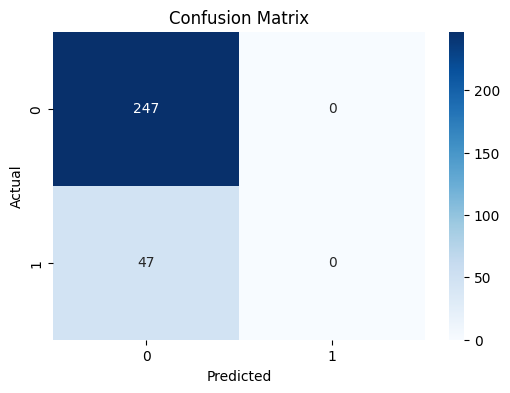

In [74]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

buffer = BytesIO()
plt.savefig(buffer, format='png')

object_name = "evaluator/logisticregression/{}/confusion_matrix.png".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "image/png"
)

object_name = "evaluator/logisticregression/latest/confusion_matrix.png"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "image/png"
)

### Random Forest

#### Prediction

In [75]:
response = client.get_object(Bucket=bucket_name, Key="builder/randomforest/latest/model.joblib")
model = joblib.load(BytesIO(response["Body"].read()))

X_test = load_npy_from_minio(bucket_name, "preprocessor/randomforest/latest/X_test.npy")
y_test = load_npy_from_minio(bucket_name, "preprocessor/randomforest/latest/y_test.npy")
y_pred = model.predict(X_test)

#### Classification report

In [76]:
report = classification_report(y_test, y_pred, output_dict=True)
buffer = BytesIO()
buffer.write(json.dumps(report, indent=2).encode("utf-8"))

object_name = "evaluator/randomforest/{}/evaluation_metrics.json".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket=bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/json"
)

object_name = "evaluator/randomforest/latest/evaluation_metrics.json"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/json"
)

{'ResponseMetadata': {'RequestId': '183E90FDD57DC51E',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"1b095a2d1acd2930fc133008b699a445"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'OEwupw==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FDD57DC51E',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:52:05 GMT'},
  'RetryAttempts': 0},
 'ETag': '"1b095a2d1acd2930fc133008b699a445"',
 'ChecksumCRC32': 'OEwupw=='}

#### Confusion matrix

{'ResponseMetadata': {'RequestId': '183E90FDE1B00E27',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"a187dfbcddd3e89ebd950952565ea450"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'CyCyeQ==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FDE1B00E27',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:52:05 GMT'},
  'RetryAttempts': 0},
 'ETag': '"a187dfbcddd3e89ebd950952565ea450"',
 'ChecksumCRC32': 'CyCyeQ=='}

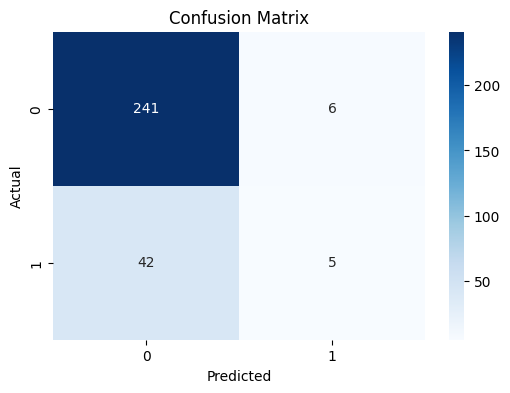

In [77]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

buffer = BytesIO()
plt.savefig(buffer, format='png')

object_name = "evaluator/randomforest/{}/confusion_matrix.png".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "image/png"
)

object_name = "evaluator/randomforest/latest/confusion_matrix.png"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "image/png"
)

### XGBoost

#### Prediction

In [78]:
response = client.get_object(Bucket=bucket_name, Key="builder/xgboost/latest/model.joblib")
model = joblib.load(BytesIO(response["Body"].read()))

X_test = load_npy_from_minio(bucket_name, "preprocessor/xgboost/latest/X_test.npy")
y_test = load_npy_from_minio(bucket_name, "preprocessor/xgboost/latest/y_test.npy")
y_pred = model.predict(X_test)

#### Classification report

In [79]:
report = classification_report(y_test, y_pred, output_dict=True)
buffer = BytesIO()
buffer.write(json.dumps(report, indent=2).encode("utf-8"))

object_name = "evaluator/xgboost/{}/evaluation_metrics.json".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket=bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/json"
)

object_name = "evaluator/xgboost/latest/evaluation_metrics.json"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "application/json"
)

{'ResponseMetadata': {'RequestId': '183E90FDF7671F8B',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"81ed4853c683c033b8e2f82a4eebaf6f"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'aIKUKQ==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FDF7671F8B',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:52:05 GMT'},
  'RetryAttempts': 0},
 'ETag': '"81ed4853c683c033b8e2f82a4eebaf6f"',
 'ChecksumCRC32': 'aIKUKQ=='}

#### Confusion matrix

{'ResponseMetadata': {'RequestId': '183E90FE02BBA95A',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '0',
   'etag': '"cd1f2e0e1a6a5bf0719c3fd57fcfdde4"',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-checksum-crc32': 'RXjbJQ==',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '183E90FE02BBA95A',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '1614',
   'x-ratelimit-remaining': '1614',
   'x-xss-protection': '1; mode=block',
   'date': 'Sun, 11 May 2025 19:52:06 GMT'},
  'RetryAttempts': 0},
 'ETag': '"cd1f2e0e1a6a5bf0719c3fd57fcfdde4"',
 'ChecksumCRC32': 'RXjbJQ=='}

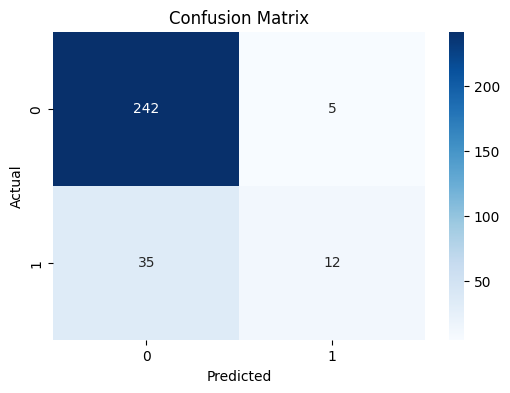

In [80]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

buffer = BytesIO()
plt.savefig(buffer, format='png')

object_name = "evaluator/xgboost/{}/confusion_matrix.png".format(timestamp)
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "image/png"
)

object_name = "evaluator/xgboost/latest/confusion_matrix.png"
buffer.seek(0)
client.put_object(
    Bucket = bucket_name,
    Key = object_name,
    Body = buffer,
    ContentType = "image/png"
)

## Registrar

In [81]:
import json
from io import BytesIO

In [ ]:
models = ["xgboost", "randomforest", "logisticregression"]
bucket = "artifacts"
metric = "f1-score"
split = "weighted avg"

def load_json_from_minio(bucket, key):
    response = client.get_object(Bucket = bucket, Key=key)
    return json.load(BytesIO(response['Body'].read()))

def copy_object(source_key, target_key):
    obj = client.get_object(Bucket = bucket, Key = source_key)
    body = obj['Body'].read()
    client.put_object(
        Bucket = bucket,
        Key = target_key,
        Body = body,
        ContentType = obj["ContentType"]
    )

In [84]:
scores = {}
for model in models:
    try:
        eval_data = load_json_from_minio(
            bucket,
            f"evaluator/{model}/latest/evaluation_metrics.json"
        )
        f1 = eval_data.get(split, {}).get(metric)
        if f1 is not None:
            scores[model] = f1
    except Exception as e:
        print(f"Error reading metrics for {model}: {e}")

best_model = max(scores, key=scores.get)

artifacts_to_copy = [
    f"builder/{best_model}/latest/model.joblib",
    f"builder/{best_model}/latest/training_metadata.json",
    f"evaluator/{best_model}/latest/evaluation_metrics.json"
]

for artifact in artifacts_to_copy:
    dest_key = artifact.replace(f"{best_model}/latest", "production")
    copy_object(artifact, dest_key)

✅ Mejor modelo: xgboost con F1 = 0.8360
📦 Registrado: builder/production/model.joblib
📦 Registrado: builder/production/training_metadata.json
📦 Registrado: evaluator/production/evaluation_metrics.json
🎯 Modelo registrado en producción correctamente.


### Logistic Regression

# Improvements

Add model comparator to add interpretability, feature importance analysis, postprocesamiento, consistency, debugging
